In [1]:
import easyocr

from PIL import Image
import pytesseract

import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
import Levenshtein as lev

from enum import IntEnum

import cv2
import os

import json


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

C:\ProgramData\Anaconda3\envs\ocr\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = r'E:\datasets\MADE\3_graduation\parthplc\archive\data\\'

train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [3]:
train_data['path'] = train_data['img'].apply(lambda x: os.path.join(data_dir, x))
train_data

id            img  label  \
0     42953  img/42953.png      0   
1     23058  img/23058.png      0   
2     13894  img/13894.png      0   
3     37408  img/37408.png      0   
4     82403  img/82403.png      0   
...     ...            ...    ...   
8495  10423  img/10423.png      1   
8496  98203  img/98203.png      1   
8497  36947  img/36947.png      1   
8498  16492  img/16492.png      1   
8499  15937  img/15937.png      1   

                                                   text  \
0      its their character not their color that matters   
1     don't be afraid to love again everyone is not ...   
2                              putting bows on your pet   
3     i love everything and everybody! except for sq...   
4     everybody loves chocolate chip cookies, even h...   
...                                                 ...   
8495                  nobody wants to hang auschwitz me   
8496  when god grants you a child after 20 years of ...   
8497  gays on social media: equality! body positivit...   
8498  having a bad day? you could be a siamese twin ...   
8499  i hate muslims too they take their religion to...   

                                                   path  
0     E:\datasets\MADE\3_graduation\parthplc\archive...  
1     E:\datasets\MADE\3_graduation\parthplc\archive...  
2     E:\datasets\MADE\3_graduation\parthplc\archive...  
3     E:\datasets\MADE\3_graduation\parthplc\archive...  
4     E:\datasets\MADE\3_graduation\parthplc\archive...  
...                                                 ...  
8495  E:\datasets\MADE\3_graduation\parthplc\archive...  
8496  E:\datasets\MADE\3_graduation\parthplc\archive...  
8497  E:\datasets\MADE\3_graduation\parthplc\archive...  
8498  E:\datasets\MADE\3_graduation\parthplc\archive...  
8499  E:\datasets\MADE\3_graduation\parthplc\archive...  

[8500 rows x 5 columns]

In [4]:
test_data['path'] = test_data['img'].apply(lambda x: os.path.join(data_dir, x))
test_data

id            img  label  \
0     8291  img/08291.png      1   
1    46971  img/46971.png      1   
2     3745  img/03745.png      1   
3    83745  img/83745.png      1   
4    80243  img/80243.png      1   
..     ...            ...    ...   
495  83675  img/83675.png      0   
496  37198  img/37198.png      0   
497  48670  img/48670.png      0   
498   9863  img/09863.png      0   
499  97320  img/97320.png      0   

                                                  text  \
0                white people is this a shooting range   
1                                bravery at its finest   
2    your order comes to $37.50 and your white priv...   
3    it is time.. to send these parasites back to t...   
4                               mississippi wind chime   
..                                                 ...   
495                   i'm gonna be like phelps one day   
496  when you're so relaxed you can feel yourself g...   
497  look at this sandwich maker club i found on wi...   
498                             diverse group of women   
499  "when your dishwasher is broken so you take it...   

                                                  path  
0    E:\datasets\MADE\3_graduation\parthplc\archive...  
1    E:\datasets\MADE\3_graduation\parthplc\archive...  
2    E:\datasets\MADE\3_graduation\parthplc\archive...  
3    E:\datasets\MADE\3_graduation\parthplc\archive...  
4    E:\datasets\MADE\3_graduation\parthplc\archive...  
..                                                 ...  
495  E:\datasets\MADE\3_graduation\parthplc\archive...  
496  E:\datasets\MADE\3_graduation\parthplc\archive...  
497  E:\datasets\MADE\3_graduation\parthplc\archive...  
498  E:\datasets\MADE\3_graduation\parthplc\archive...  
499  E:\datasets\MADE\3_graduation\parthplc\archive...  

[500 rows x 5 columns]

In [5]:
easyocr_reader = easyocr.Reader(['ru','en']) # this needs to run only once to load the model into memory

In [6]:
class ImageTransformType(IntEnum):
    No = 0
    Gray = 1
    Binary = 2
    BinaryInv = 3
    AdaptiveMean = 4
    AdaptiveMeanInv = 5
    AdaptiveGaussian = 6
    AdaptiveGaussianInv = 7

In [7]:
def recognize(path:list, recognizer_name: str, image_transform: ImageTransformType, thresh: int, maxval: int, 
              block_size:int, c:float) -> list:
    recognized_text = []    
    for i in range(len(path)):
        #print(path[i])
        image = cv2.imread(path[i], cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        if image_transform == ImageTransformType.Gray:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
        if image_transform == ImageTransformType.Binary:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, image = cv2.threshold(image, thresh, maxval, cv2.THRESH_BINARY)
            
        if image_transform == ImageTransformType.BinaryInv:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, image = cv2.threshold(image, thresh, maxval, cv2.THRESH_BINARY_INV)

        if image_transform == ImageTransformType.AdaptiveMean:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            
            image = cv2.adaptiveThreshold(image, maxval, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)

        if image_transform == ImageTransformType.AdaptiveMeanInv:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            
            image = cv2.adaptiveThreshold(image, maxval, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, block_size, c)
            
        if image_transform == ImageTransformType.AdaptiveGaussian:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            
            image = cv2.adaptiveThreshold(image, maxval, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
            
        if image_transform == ImageTransformType.AdaptiveGaussianInv:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            
            image = cv2.adaptiveThreshold(image, maxval, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, c)
            
        if recognizer_name == 'easyocr':            
            recognized_text.append(' '.join(easyocr_reader.readtext(image, detail=0)))
            
        elif recognizer_name == 'pytesseract':
            recognized_text.append(pytesseract.image_to_string(image).replace('\n', ' '))
            
    return recognized_text, image



# Примеры pytesseract без предобработки и с ней

TEXT: its their character not their color that matters
 OCR: its their character  "  y  .)  a  not their color, that Need 


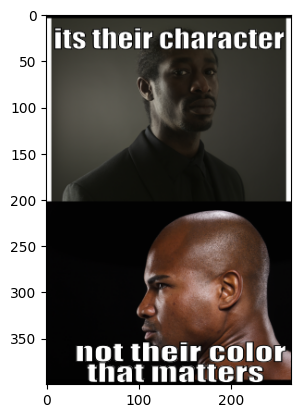

TEXT: don't be afraid to love again everyone is not like your ex
 OCR: Hlonmtnerainaid to foue ‘again,  


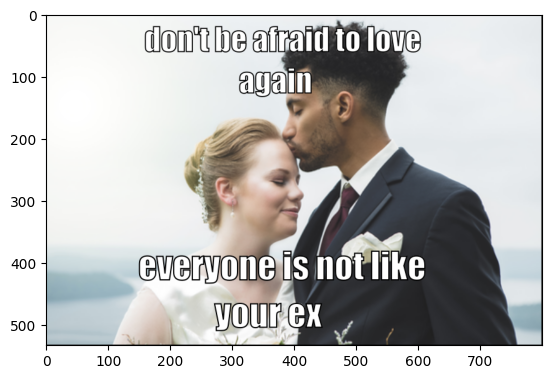

TEXT: putting bows on your pet
 OCR: Ing DOWs OLVOUr Det  


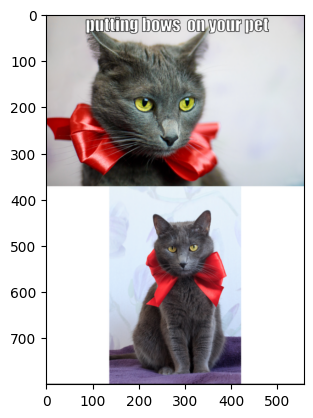

TEXT: i love everything and everybody! except for squirrels i hate squirrels
 OCR: Mioiereverything anteueniiod  ae a  “t . ya oe except for squirrels ihatelsquirrels 


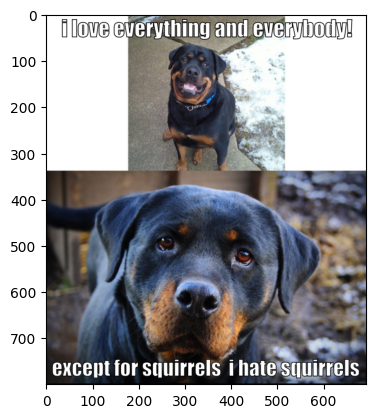

TEXT: everybody loves chocolate chip cookies, even hitler
 OCR: everybody loves chocolate}  is  chip cookies, even hitler  . 


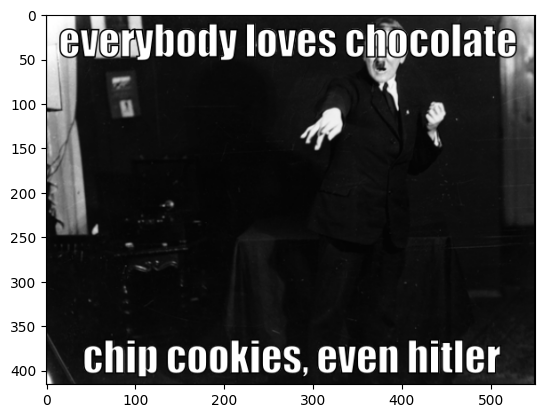

TEXT: white people is this a shooting range
 OCR: ileistiisashootin  y gre 


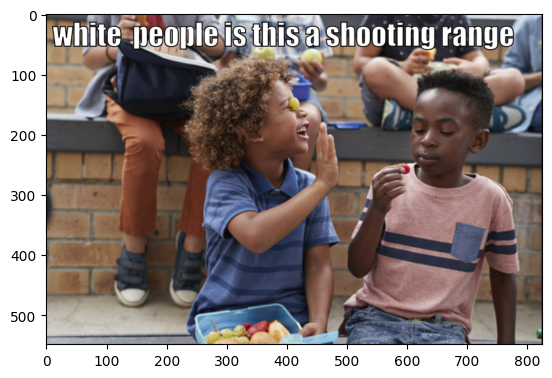

TEXT: bravery at its finest
 OCR: 


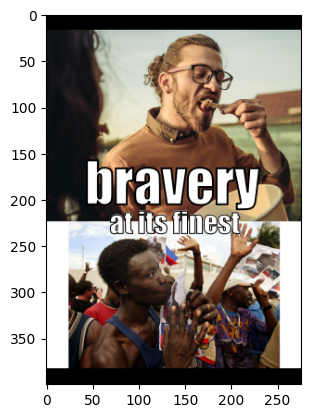

TEXT: your order comes to $37.50 and your white privilege discount brings the total to $37.50
 OCR: Santon Ds Fe - (1) tO 


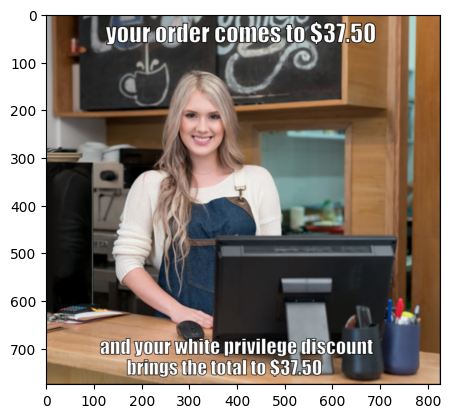

TEXT: it is time.. to send these parasites back to the desert
 OCR: tosend in Marasiteste psend ees lesert 


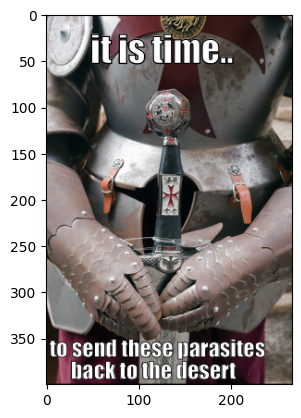

TEXT: mississippi wind chime
 OCR: 


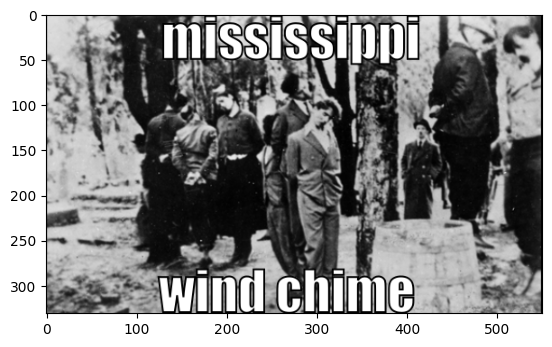

In [22]:
for i in range(5):
    recognized_text, image = recognize([train_data.loc[i, 'path']], 
     recognizer_name='pytesseract', 
     image_transform=ImageTransformType.No, 
     thresh=0, 
     maxval=0,
     block_size=0,
     c=0)
    
    print('TEXT: ', train_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image)
    plt.show()
    

for i in range(5):
    recognized_text, image = recognize([test_data.loc[i, 'path']], 
     recognizer_name='pytesseract', 
     image_transform=ImageTransformType.No, 
     thresh=0, 
     maxval=0,
     block_size=0,
     c=0)
    
    print('TEXT: ', test_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image)
    plt.show()   

TEXT: its their character not their color that matters
 OCR: its their character  hot their color that matters 


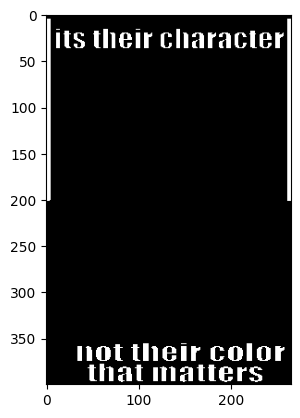

TEXT: don't be afraid to love again everyone is not like your ex
 OCR: don't he afraid to love  r again  everyone is not like Our eX 


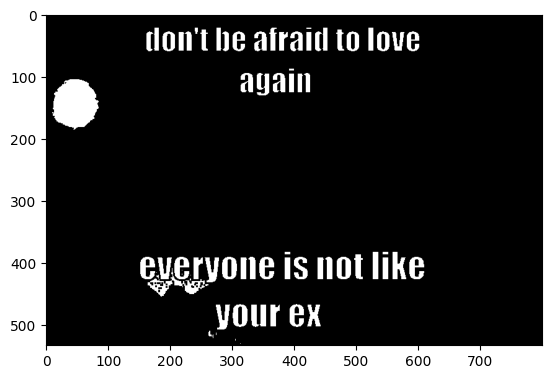

TEXT: putting bows on your pet
 OCR: putting hows on your pet  


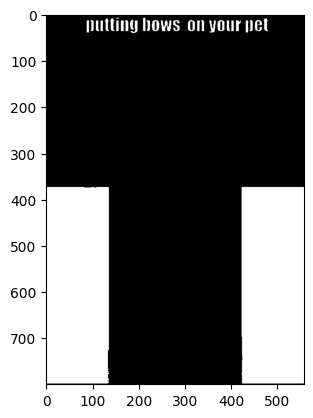

TEXT: i love everything and everybody! except for squirrels i hate squirrels
 OCR: iMlovereverything and Bare ios  except for squirrels ihate squirrels 


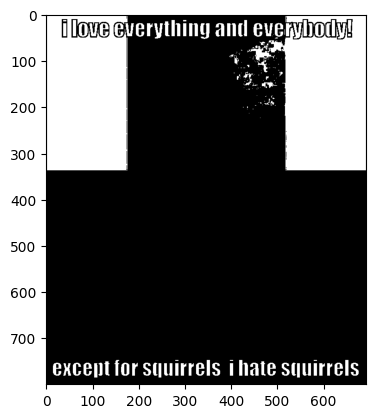

TEXT: everybody loves chocolate chip cookies, even hitler
 OCR: "everyhotly loves chocolate  chip cookies, even hitler 


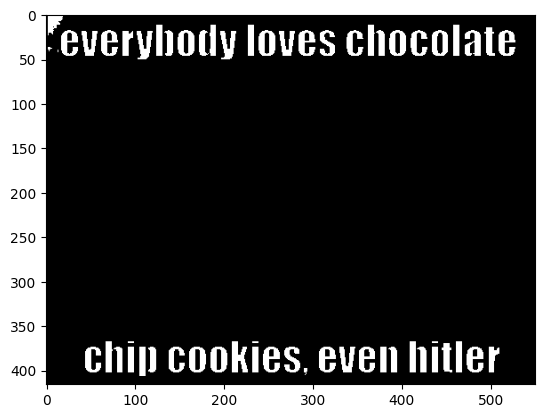

TEXT: white people is this a shooting range
 OCR: white people is this a shooting range 


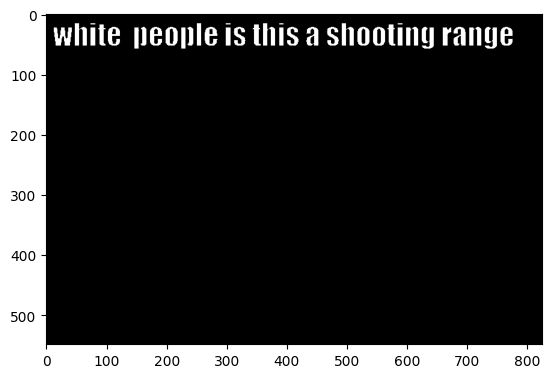

TEXT: bravery at its finest
 OCR: bravery  aLilsfinest 


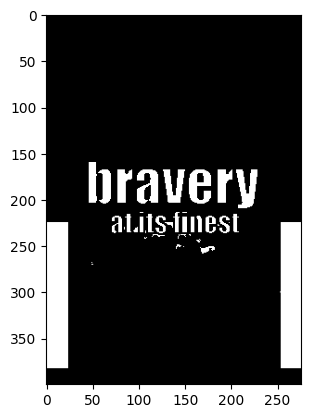

TEXT: your order comes to $37.50 and your white privilege discount brings the total to $37.50
 OCR: your order comes to $37.50  and your white privilege discount hrings the total to $37.50 


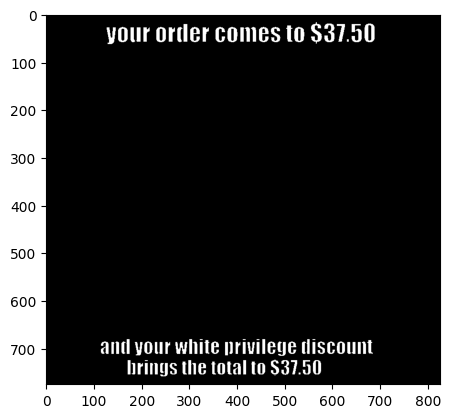

TEXT: it is time.. to send these parasites back to the desert
 OCR: itis time..  to send these parasites hack to the desert 


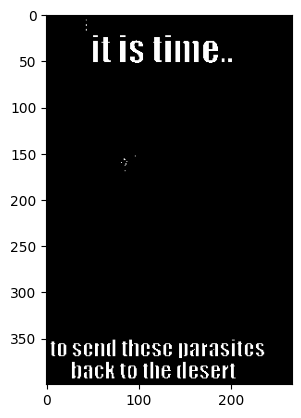

TEXT: mississippi wind chime
 OCR: mississippi  wind chime 


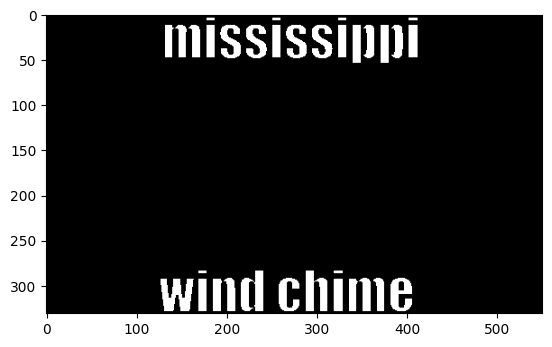

In [23]:
#Value: 0.015120000000000001
#Parameters: {'image_transform': <ImageTransformType.Binary: 2>, 'thresh': 253, 'maxval': 158}


for i in range(5):
    recognized_text, image = recognize([train_data.loc[i, 'path']], 
     recognizer_name='pytesseract', 
     image_transform=ImageTransformType.Binary, 
     thresh=253, 
     maxval=158,
     block_size=0,
     c=0)
    
    print('TEXT: ', train_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image, cmap='gray')
    plt.show()
    

for i in range(5):
    recognized_text, image = recognize([test_data.loc[i, 'path']], 
     recognizer_name='pytesseract', 
     image_transform=ImageTransformType.Binary, 
     thresh=253, 
     maxval=158,
     block_size=0,
     c=0)
    
    print('TEXT: ', test_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image, cmap='gray')
    plt.show()   

# Примеры easyocr без предобработки и с ней

TEXT: its their character not their color that matters
 OCR: [its their character not mheir color Iharmaшer:


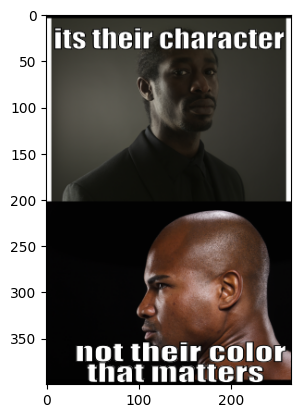

TEXT: don't be afraid to love again everyone is not like your ex
 OCR: domiubgalmald1.m agaim @LGL1me[S mOt [ikе ШОШЕ @K


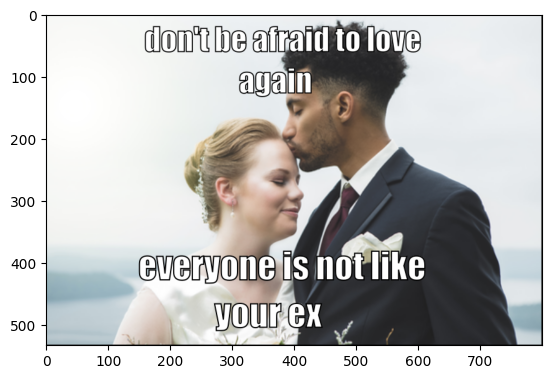

TEXT: putting bows on your pet
 OCR: [u(ilmg[ONS ОМ ОШ.[Gl


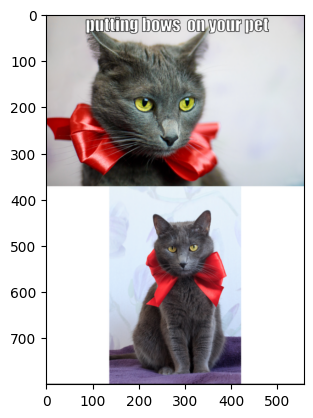

TEXT: i love everything and everybody! except for squirrels i hate squirrels
 OCR: [[ОШС СПеГИЕшgаm@GПОШ eKGeIIt for suluirrelS hale Suuimfels


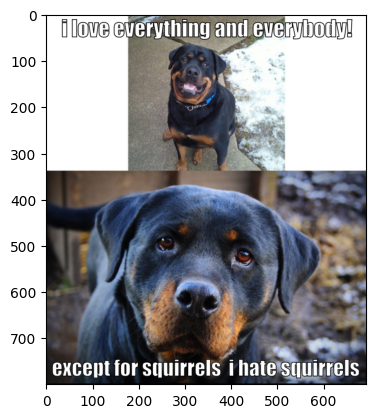

TEXT: everybody loves chocolate chip cookies, even hitler
 OCR: @U@mhoduloues chocolale chin cookies; euen hiuler


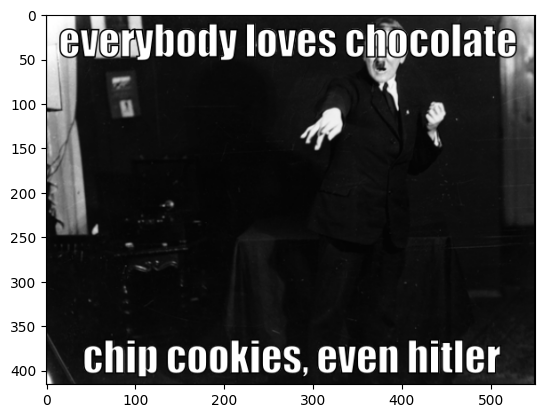

TEXT: white people is this a shooting range
 OCR: [hiue p@OpleiStisashootingramge


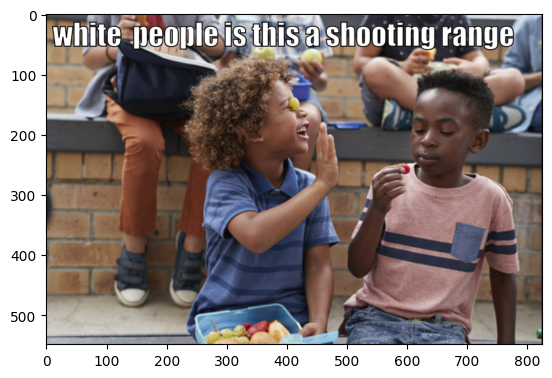

TEXT: bravery at its finest
 OCR: bralerl alllS iGSln


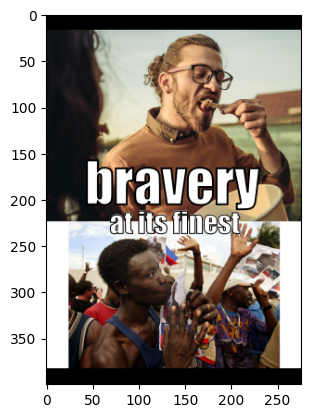

TEXT: your order comes to $37.50 and your white privilege discount brings the total to $37.50
 OCR: yOu< OGder GOmGS [O $37.50 amd[OuEmhile [riuileue discOumt [imgStetoualt83l50


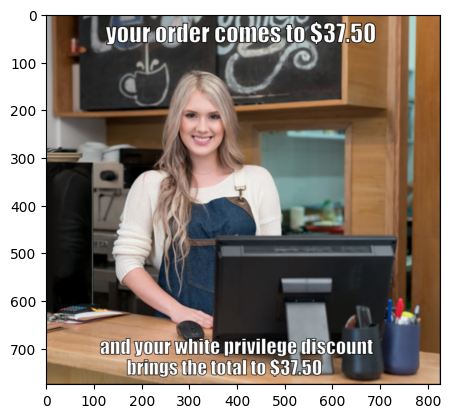

TEXT: it is time.. to send these parasites back to the desert
 OCR: [tistime: 10 selld Ihese [larasiles hack -0[he desert


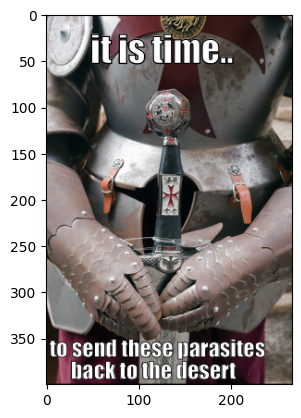

TEXT: mississippi wind chime
 OCR: miSSLSSi[IN mimdchim@


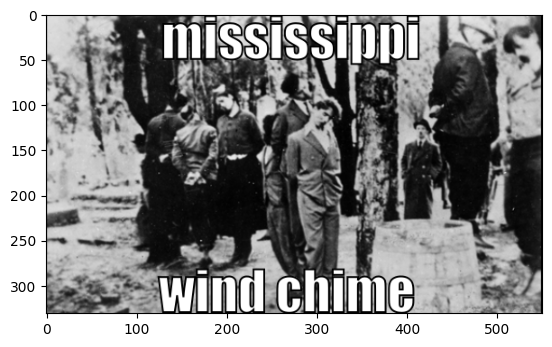

In [24]:
for i in range(5):
    recognized_text, image = recognize([train_data.loc[i, 'path']], 
     recognizer_name='easyocr', 
     image_transform=ImageTransformType.No, 
     thresh=0, 
     maxval=0,
     block_size=0,
     c=0)
    
    print('TEXT: ', train_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image)
    plt.show()
    

for i in range(5):
    recognized_text, image = recognize([test_data.loc[i, 'path']], 
     recognizer_name='easyocr', 
     image_transform=ImageTransformType.No, 
     thresh=253, 
     maxval=95,
     block_size=0,
     c=0)
    
    print('TEXT: ', test_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image)
    plt.show()

TEXT: its their character not their color that matters
 OCR: its Шeir characlerl шot tleir color that matters


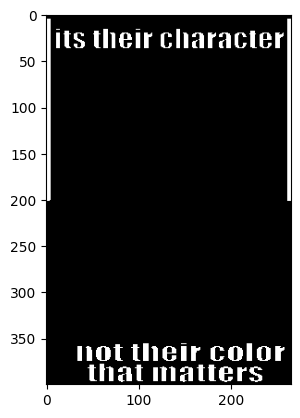

TEXT: don't be afraid to love again everyone is not like your ex
 OCR: [lom't he afraidl t0 l0ue aaill eueryome is mlOt like VOWI eЖ


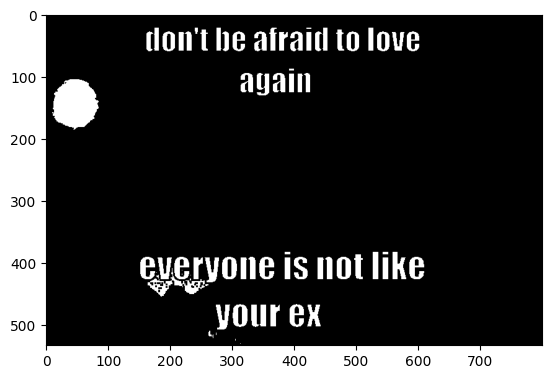

TEXT: putting bows on your pet
 OCR: IllItIinlg hows OIl VOlII [lel


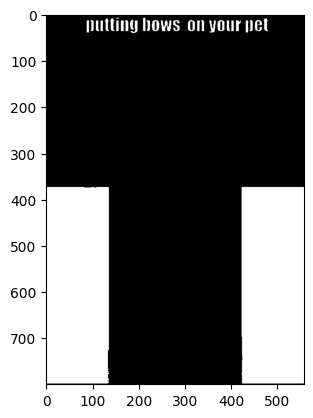

TEXT: i love everything and everybody! except for squirrels i hate squirrels
 OCR: [[UшGuervtling andl @UeПЮШЮ eKcelt for slluirrels ihale sululrrels


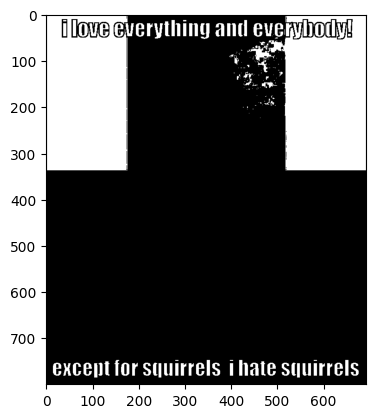

TEXT: everybody loves chocolate chip cookies, even hitler
 OCR: everyhotly loues chocolate chill cookies; eUell hiller


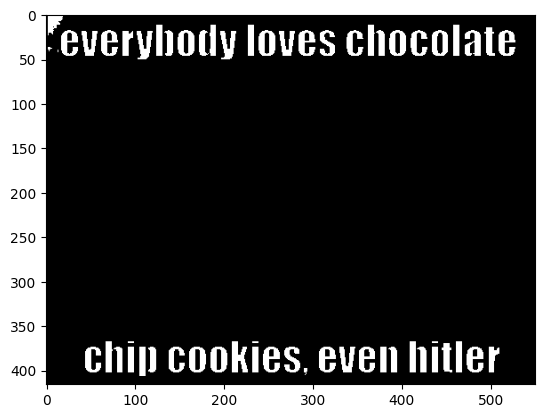

TEXT: white people is this a shooting range
 OCR: white mleomlle is Ihis a shooling range


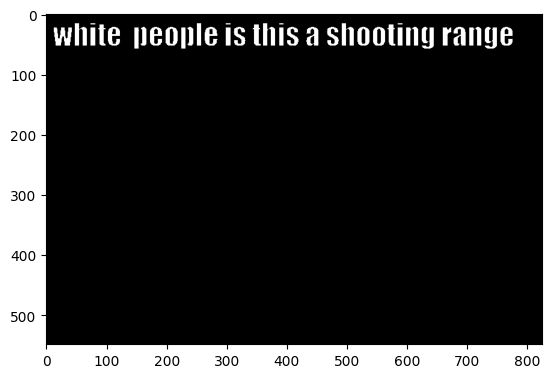

TEXT: bravery at its finest
 OCR: hurauery aLIIS-finest


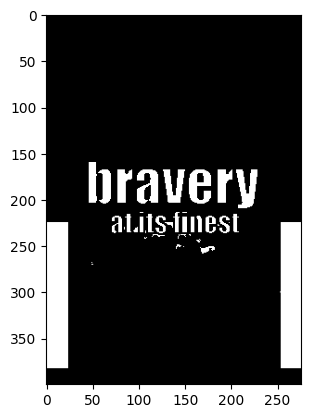

TEXT: your order comes to $37.50 and your white privilege discount brings the total to $37.50
 OCR: VOlr Orller comleS [0 $37.50 aml vouF white Ilriuilege Iliscoulll [#rings tle total t0 $37.50


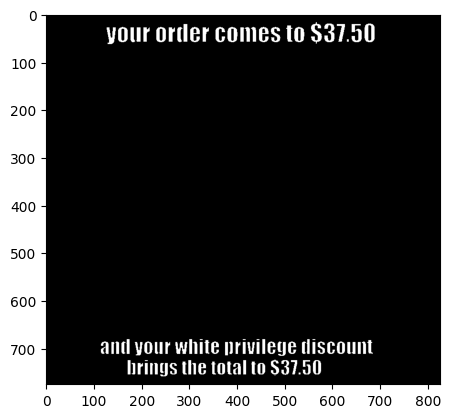

TEXT: it is time.. to send these parasites back to the desert
 OCR: itis timlle. ID SGIlIl thcse mlarasiIcS hach tD Ille Ilesert


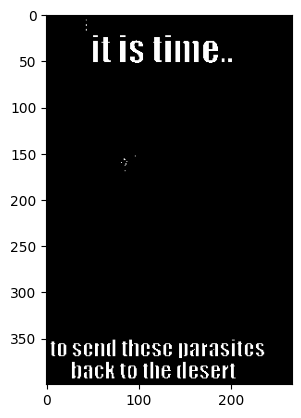

TEXT: mississippi wind chime
 OCR: IIISSISSIIJIII Wimil chime


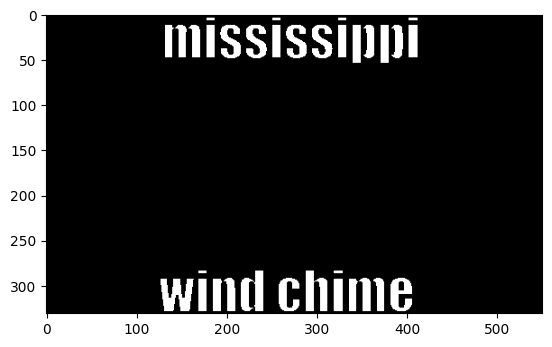

In [25]:
#Value: 0.04052800000000001
#Parameters: {'image_transform': <ImageTransformType.BinaryInv: 3>, 'thresh': 253, 'maxval': 95}

for i in range(5):
    recognized_text, image = recognize([train_data.loc[i, 'path']], 
     recognizer_name='easyocr', 
     image_transform=ImageTransformType.Binary, 
     thresh=253, 
     maxval=95,
     block_size=0,
     c=0)
    
    print('TEXT: ', train_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image, cmap='gray')
    plt.show()
    

for i in range(5):
    recognized_text, image = recognize([test_data.loc[i, 'path']], 
     recognizer_name='easyocr', 
     image_transform=ImageTransformType.Binary, 
     thresh=253, 
     maxval=95,
     block_size=0,
     c=0)
    
    print('TEXT: ', test_data.loc[i, 'text'], '\n', ' OCR: ', recognized_text[0], sep='')
    plt.imshow(image, cmap='gray')
    plt.show()